In [76]:
%pip install bibtexparser --pre
%pip install pandas
%pip install lmfit
%pip install tabulate
%pip install pybroom

# Rheomodel lite test

In this notebook the test the compatibility of rheomodel with pyodyde kernel running on jupyterlite.

Since rheomodel is not yet pip installable to import it we copy the library files directly from github into the rhomodel foldel

In [19]:
# download rheomodel library

from pyodide.http import open_url
import os

folder='./rheomodel/'
try:
    os.mkdir(folder)
except:
    pass

def download_file(url, filename=None, folder=None):
    if filename is None:
        filename=url.split('/')[-1]
        
    if folder is None:
        folder='./'
        
    with open(folder + filename, 'w') as file:
        file.write(open_url(url).read())
        
url_list=["https://raw.githubusercontent.com/rheopy/rheomodel/master/rheomodel/__init__.py",
          "https://raw.githubusercontent.com/rheopy/rheomodel/master/rheomodel/models.py",
          "https://raw.githubusercontent.com/rheopy/rheomodel/master/rheomodel/models.bib",
          "https://raw.githubusercontent.com/rheopy/rheomodel/master/rheomodel/functions.py"]
          
for url in url_list:
    download_file(url, folder='./rheomodel/')

## Quickstart

### Indended use

In [77]:
#easy access to rheology model for flow curve fitting

import lmfit
import pybroom
import rheomodel as rm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, Latex

model=lmfit.Model(rm.HB)
model.param_names

['ystress', 'K', 'n']

In [23]:
#simulated data for fitting example

x=np.logspace(-3,3)
data=pd.DataFrame({'Shear rate':x,'Stress':rm.TC(x,ystress=10,gammadot_crit=0.1,eta_bg=0.8)})
display(Markdown(data.head().to_markdown()))

|    |   Shear rate |   Stress |
|---:|-------------:|---------:|
|  0 |   0.001      |  11.0008 |
|  1 |   0.00132571 |  11.1525 |
|  2 |   0.00175751 |  11.3271 |
|  3 |   0.00232995 |  11.5283 |
|  4 |   0.00308884 |  11.76   |

In [49]:
#using lmfit to perform the fit
condition=data['Shear rate']>0
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=condition/(0.1*data['Stress']))
res_fit

<AxesSubplot:title={'center':'Model(HB)'}, xlabel='$\\dot\\gamma$ [1/s]', ylabel='$\\sigma$ [Pa]'>

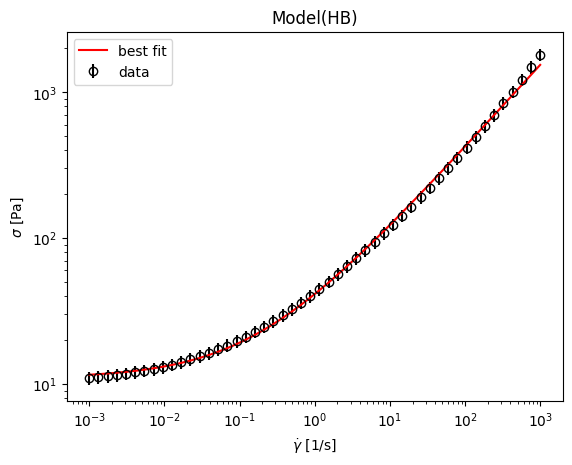

In [63]:
res_fit.plot_fit(xlabel='$\dot\gamma$ [1/s]',
                 ylabel='$\sigma$ [Pa]',
                 fitfmt='-',
                 ax_kws={'yscale':'log', 'xscale':'log'},
                 data_kws={'mfc':'none', 'color':'black'},
                 fit_kws={'color':'red'})

<AxesSubplot:title={'center':'Model(HB)'}, ylabel='residuals'>

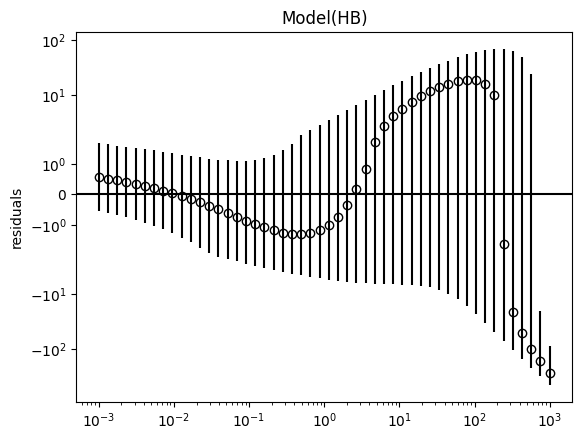

In [72]:
res_fit.plot_residuals(data_kws={'mfc':'none', 'color':'black'},ax_kws={'yscale':'symlog', 'xscale':'log'})

# Explore available models

In [73]:
import rheomodel as rm
display(Markdown(rm.library_to_table(rm.library).to_markdown()))

| ID                     | author                                                      | title                                                                                                                                                             | publisher                                  |   year | address   | journal                                                   |   volume |   number | pages      |
|:-----------------------|:------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------|-------:|:----------|:----------------------------------------------------------|---------:|---------:|:-----------|
| newton_1687            | Isaac Newton                                                | Philosophiæ Naturalis Principia Mathematica                                                                                                                       | Josephi Streater                           |   1687 | London    | nan                                                       |      nan |      nan | nan        |
| ostwald_1929           | Ostwald, Wilhelm                                            | Über die Geschwindigkeitsfunktion der Newton'schen Viscosität                                                                                                     | Walter de Gruyter                          |   1929 | nan       | Zeitschrift für physikalische Chemie                      |      102 |        1 | 64--79     |
| bingham_1916           | Bingham, Eugene C.                                          | A new conception of plasticity and viscous flow                                                                                                                   | Elsevier                                   |   1916 | nan       | The Journal of the Franklin Institute                     |      181 |        6 | 543--552   |
| herschel_bulkley_1926  | Herschel, Winslow Hobart and Bulkley, Robert                | Measurement of consistency as applied to rubber-benzene solutions                                                                                                 | American Society for Testing and Materials |   1926 | nan       | Proceedings of the American Society for Testing Materials |       26 |        2 | 621--633   |
| carreau_yasuda_1979    | Carreau, Pierre J. and Yasuda, Koichi                       | Rheological equations from molecular network theories                                                                                                             | Wiley                                      |   1979 | nan       | Journal of Polymer Science                                |       11 |        2 | 371--388   |
| cross_1925             | Cross, Malcolm M.                                           | Viscosity of Colloids                                                                                                                                             | ACS Publications                           |   1925 | nan       | The Journal of Physical Chemistry                         |       29 |       11 | 1409--1426 |
| caggioni2020variations | Caggioni, Marco and Trappe, Veronique and Spicer, Patrick T | Variations of the Herschel--Bulkley exponent reflecting contributions of the viscous continuous phase to the shear rate-dependent stress of soft glassy materials | AIP Publishing                             |   2020 | nan       | Journal of Rheology                                       |       64 |        2 | 413--422   |

In [74]:
for ID, model in rm.models.model_dict.items():
    display(ID, Latex(model.latex))

'caggioni2020variations'

<IPython.core.display.Latex object>

'herschel_bulkley_1926'

<IPython.core.display.Latex object>

'newton_1687'

<IPython.core.display.Latex object>

'ostwald_1929'

<IPython.core.display.Latex object>

'cross_1925'

<IPython.core.display.Latex object>

'bingham_1916'

<IPython.core.display.Latex object>

In [92]:
#a possible use is to iterate through models and check which one gives the best fit

condition=data['Shear rate']>0
res_dict={}
for ID, python_model in rm.models.model_dict.items():
    lmfit_model=lmfit.Model(python_model)
    try:
        res_dict[lmfit_model.name]=lmfit_model.fit(data['Stress'],x=data['Shear rate'],weights=condition/(0.1*data['Stress']))
        display(ID, Latex(python_model.latex))

    except:
        print('fit did not converged 🙁')

        
pybroom.glance(res_dict)

'caggioni2020variations'

<IPython.core.display.Latex object>

'herschel_bulkley_1926'

<IPython.core.display.Latex object>

'newton_1687'

<IPython.core.display.Latex object>

'ostwald_1929'

<IPython.core.display.Latex object>

fit did not converged 🙁


'bingham_1916'

<IPython.core.display.Latex object>

,model,method,num_params,num_data_points,chisqr,redchi,AIC,BIC,num_func_eval,success,message,key
0,Model(TC),leastsq,3,50,4.396130e-26,9.353468e-28,-3108.925542,-3103.189473,9,True,Fit succeeded.,Model(TC)
1,Model(HB),leastsq,3,50,1.083543e+01,2.305411e-01,-70.460083,-64.724014,42,True,Fit succeeded.,Model(HB)
2,Model(Newtonian),leastsq,1,50,3.380576e+03,6.899135e+01,212.688921,214.600944,5,True,Fit succeeded.,Model(Newtonian)
3,Model(Powerlaw),leastsq,2,50,4.916751e+02,1.024323e+01,118.289758,122.113804,66,True,Fit succeeded.,Model(Powerlaw)
4,Model(Bingham),leastsq,2,50,8.475509e+02,1.765731e+01,145.516392,149.340438,7,True,Fit succeeded.,Model(Bingham)


In [98]:
long_table=pybroom.tidy(res_dict)
wide_table=long_table.pivot(index='key',columns='name',values='value')
wide_table

name,K,eta,eta_bg,gammadot_crit,n,ystress
key,,,,,,
Model(Bingham),NaN,NaN,2.919573,NaN,NaN,15.243747
Model(HB),30.357025,NaN,NaN,NaN,0.567337,10.963153
Model(Newtonian),NaN,3.095506,NaN,NaN,NaN,NaN
Model(Powerlaw),54.712417,NaN,NaN,NaN,0.379223,NaN
Model(TC),NaN,NaN,0.800000,0.1,NaN,10.000000
